In [2]:
from __future__ import print_function
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf


pd.options.display.max_columns = None
register_matplotlib_converters()


%matplotlib inline

In [3]:
assert tf.__version__.startswith('2'), tf.__version__

In [3]:
%pip install ortools

from ortools.linear_solver import pywraplp

# need to restart notebook after installing first time
_ = pywraplp.Solver('LinearProgrammingGridworld', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [4]:
# random strategy, gamma=0.9
expected_values_random = np.array([
    [ 3.3,  8.8,  4.4,  5.3,  1.5],
    [ 1.5,  3.0,  2.3,  1.9,  0.5],
    [ 0.1,  0.7,  0.7,  0.4, -0.4],
    [-1.0, -0.4, -0.4, -0.6, -1.2],
    [-1.9, -1.3, -1.2, -1.4, -2.0],
])
# optimal strategy, gamma=0.9
expected_values = np.array([
    [22.0, 24.4, 22.0, 19.4, 17.5],
    [19.8, 22.0, 19.8, 17.8, 16.0],
    [17.8, 19.8, 17.8, 16.0, 14.4],
    [16.0, 17.8, 16.0, 14.4, 13.0],
    [14.4, 16.0, 14.4, 13.0, 11.7]
])

## Actions
[North](https://www.youtube.com/watch?v=K31sJIbv_20), [East](https://www.youtube.com/watch?v=dq3rVbGCijo), [West](https://www.youtube.com/watch?v=2LVLo61M0rY), [South](https://www.youtube.com/watch?v=zRYQJw_pYgY)

In [5]:
from enum import Enum


class Action(Enum):
    NORTH = 'N', 0, lambda x: (x[0] - 1, x[1]), (0, 1)
    EAST = 'E', 1, lambda x: (x[0], x[1] + 1), (1, 0)
    WEST = 'W', 2, lambda x: (x[0], x[1] - 1), (-1, 0)
    SOUTH = 'S', 3, lambda x: (x[0] + 1, x[1]), (0, -1)
    def __init__(self, display_name, index, transition, direction):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # numpy row-major coordinates
        self.direction = direction  # matplotlib coordinates

    def __str__(self):
        return self.display_name

## Agents

In [6]:
class Agent(object):
    def __init__(self, name):
        self.name = name

    def policy(self, state):
        """Return an Action given STATE"""
        raise NotImplementedError()


In [7]:
class RandomAgent(Agent):
    """ Randomly select an action at each timestep. Used to evaluate policy prediction. """
    def __init__(self, name='Random'):
        super().__init__(name)
        self.state_values = np.random.randn(5, 5)

    def policy(self, state):
        return random.choice([a for a in Action])

In [8]:
class GreedyAgent(Agent):
    """
    This agent has perfect information regarding the environment transition probabilities and rewards.

    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, state_values=None, name='Optimal', gamma=0.9):
        super().__init__(name)
        if state_values is None:
            state_values = np.random.randn(5, 5)
        self.state_values = state_values  # v(s)
        self.gamma = gamma

        self.environment = Gridworld()

    def policy(self, state):
        """Policy iteration using the exact transition/reward outcomes."""
        action = None
        max_action_value = -1000
        for a in Action:
            self.environment.set_state(state)
            s1, r = self.environment.transition(a)

            action_value = r + self.gamma * self.state_values[s1]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value

        return action

In [9]:
class EpsilonGreedyAgent(GreedyAgent):
    """
    GreedyAgent with epsilon greedy exploration.

    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, epsilon=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])

        return super().policy(state)

In [10]:
class LearnedAgent(Agent):
    """Learn the Optimal Policy beginning with a random policy and no priors."""
    def __init__(self, name='Learned', gamma=0.9, dim=5, epsilon=0):
        super().__init__(name)
        self.action_values = np.random.randn(5, 5, 4)  # q(s, a)
        self._policy = {s: random.choice([a for a in Action])
                        for s in product(range(dim), range(dim))}
        self.gamma = gamma
        self.epsilon = epsilon

    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])
        return self._policy[state]

    def update_state_policy(self, s):
        old_action = self._policy[s]
        stable = True
        max_action_value = -1000
        for a in Action:
            action_value = self.action_values[(s[0], s[1], a.index)]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
        if action != old_action:
            policy_stable = False
        self._policy[s] = action
        return stable

    def policy_improvement(self):
        """Update our policy based on our latest action_values"""
        policy_stable = True
        for s in self._policy.keys():
            stable = self.update_state_policy(s)
            if not stable:
                policy_stable = False

        return policy_stable

## Environment

In [11]:
class Gridworld(object):
    def __init__(self, initial_state=(0, 0)):
        self.dim = 5
        self.state = initial_state

    def set_state(self, state):
        self.state = state

    def _transition_state(self, action):
        """Try to apply the ACTION and check whether it is valid"""
        x, y = action.transition(self.state)
        if x < 0 or x >= self.dim:
            return self.state
        elif y < 0 or y >= self.dim:
            return self.state
        return x, y

    def transition(self, action):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = 0
        if self.state == (0, 1):  # special state A
            new_state = (4, 1)
            reward = 10
        elif self.state == (0, 3):  # specal state B
            new_state = (2, 3)
            reward = 5
        else:
            new_state = self._transition_state(action)
            # invalid move
            if new_state == self.state:
                reward = -1

        self.state = new_state
        return new_state, reward

In [12]:
def display_state_values(state_values, title=None, save_path=None, plot_actions=True):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    if title:
        ax.set_title(title)
    # Transform row-major numpy coords to matplotlib coords
    transformed_values = np.rot90(state_values.T)
    im = ax.imshow(transformed_values, cmap='hot')
    fig.colorbar(im, ax=ax)

    if plot_actions:
        agent = GreedyAgent(state_values)
        for s in product(range(5), range(5)):
            action = agent.policy(s)
            dx, dy = action.direction

            # Transform row-major numpy coords to matplotlib coords
            x, y = s[1], 4 - s[0]
            ax.arrow(x - 0.25 * dx, y - 0.25 * dy, 0.5 * dx, 0.5 * dy, head_width=0.05)

    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    if save_path:
        plt.savefig(save_path)
    plt.show()


def display_state(state, fig=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
    grid = np.zeros((5, 5))
    grid[state[0], state[1]] = 1
    ax.imshow(grid, cmap='viridis')
    display(fig)
    clear_output(wait=True)
    plt.show()

## Inspect the OptimalAgent
Given the textbook solution, our agent generally moves straight to position `(1, 4)` to collect the 10 reward.

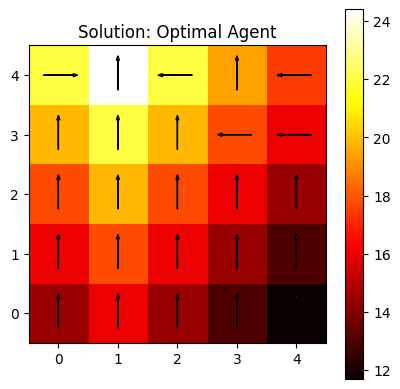

In [14]:
display_state_values(expected_values, title='Solution: Optimal Agent')

### Temporal Difference Prediction

In [15]:
def td_prediction(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = RandomAgent(name='TD Prediction: Random Agent')
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'TD Prediction: Iteration {i}')

        # Simulate episode
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        for _ in range(T):

            # Agent interacts with the environment
            a0 = agent.policy(s0)
            s1, r1 = environment.transition(a0)

            # Update state values v(s)
            v0 = agent.state_values[s0]
            v1 = agent.state_values[s1]
            agent.state_values[s0] = v0 + alpha * (r1 + gamma * v1 - v0)

            # Prep the next timestep
            s0 = s1
    return agent

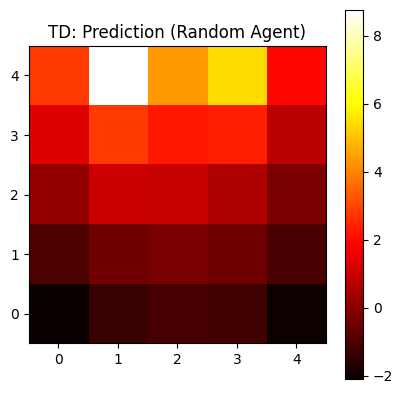

array([[ 2.77368182,  8.75964757,  4.37656827,  5.42172167,  1.99762557],
       [ 1.33786742,  2.7829529 ,  2.23858721,  2.34755412,  0.77109961],
       [ 0.11870188,  1.05250532,  0.95492818,  0.55643249, -0.24678434],
       [-1.03307273, -0.42766988, -0.29731714, -0.4299115 , -1.07947233],
       [-2.11236535, -1.33172638, -1.10432519, -1.25819078, -2.01124296]])

In [16]:
tdp_agent = td_prediction(0.05, iterations=int(1e4), T=16)
display_state_values(tdp_agent.state_values, title='TD: Prediction (Random Agent)', plot_actions=False)
tdp_agent.state_values

### Temporal Difference Control (SARSA)

In [17]:
# SARSA
def td_control(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = LearnedAgent(name='TD Control', epsilon=0.01)  # this doesn't work without some exploration
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'TD Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        sa0 = (x, y, a0.index)
        environment.set_state((x, y))
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            a1 = agent.policy(s1)

            sa1 = (s1[0], s1[1], a1.index)
            q0 = agent.action_values[sa0]
            q1 = agent.action_values[sa1]

            # On-Policy update, mid-episode
            agent.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            agent.update_state_policy((sa0[0], sa0[1]))

            # Prep the next timestep
            a0 = a1
            sa0 = sa1

    return agent


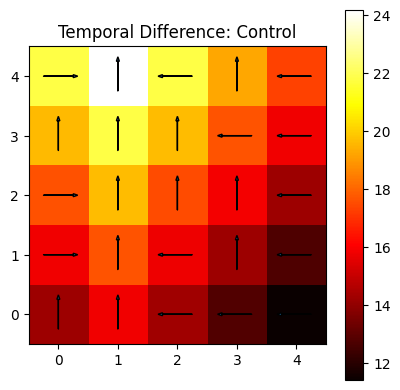

array([[21.79428746, 24.16211581, 21.78659818, 19.240609  , 17.28960628],
       [19.61711925, 21.77557466, 19.65272555, 17.67864786, 15.80277764],
       [17.60989855, 19.63401749, 17.49845259, 15.88196346, 14.22437122],
       [15.8285583 , 17.65937715, 15.75974796, 14.24143385, 12.72940781],
       [14.23567121, 15.7913365 , 14.25141882, 12.79617811, 11.40348552]])

In [18]:
tdc_agent = td_control(0.05, iterations=int(1e4), T=16)
display_state_values(tdc_agent.action_values.max(axis=2), title='Temporal Difference: Control')
tdc_agent.action_values.max(axis=2)